In [3]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

import analysis_functions

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

/home/prubbens/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Import the dataframes: 

In [4]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
data_rel = pd.read_csv('data/Chloroplasts_removed/nochloro_relative_otu.tsv', sep=' ', index_col=None, header=0)
target = pd.read_csv('data/Chloroplasts_removed/nochloro_HNA_LNA.tsv', sep=' ', index_col=0, header=0)
productivity = pd.read_csv('data/Chloroplasts_removed/productivity_data.tsv', sep=' ', index_col=0, header=0)

In [5]:
'''Set sample names as index and shuffle data'''
data_abs.set_index(target.samples,inplace=True)
data_rel.set_index(target.samples,inplace=True)
data_abs = data_abs.sample(frac=1, random_state=3)
data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
productivity = productivity.sample(frac=1, random_state=3)

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna_rel.index)

**Preprocessing of data**: filter out those OTUs which have very low abundances and so give rise to (almost) zero-columns. Therefore an OTU has to have a minimal relative abundance one, defined by the parameter _abun_. However, I use a **second constraint** which states that an OTU must have a relative abundance > _abun_ in one of the **productivity** samples. In this way we're going to bias the OTU-selection towards the ones present in the productivity samples. 

**Additionally**: there seem to be three outlier samples amongst the productivity samples. Therefore these are removed and not considered in the rest of the analysis. This leaves us with **20 samples**. 

In [6]:
from sklearn.linear_model import LinearRegression
from analysis_functions import get_r2
from scipy.stats import linregress

#retain only productivity samples 
productivity = productivity.dropna(subset=['tot_bacprod'])
#remove high productivity samples (>90)
productivity = productivity[productivity.tot_bacprod < 90]

idx_prod = productivity.samples.values
#display(idx_prod)
prod = pd.Series(productivity.tot_bacprod.values, index=idx_prod)
prod_error = pd.Series(productivity.SD_tot_bacprod.values, index=idx_prod)
prod_rel_error = prod_error/prod

In [7]:
abun = 0.0075

In [8]:
from analysis_functions import preprocess_df
data_abs_prod = data_abs.loc[idx_prod,:] 
data_abs_prod = preprocess_df(data_abs_prod,abun,True)
otus_prod = list(data_abs_prod.columns)

print('Number of OTUs: ' + str(len(otus_prod)))

Number of OTUs: 95


This leaves us with 95 OTU's (instead of 97); 

**Standardize data**: 

In [9]:
scaler = StandardScaler()
data_abs = pd.DataFrame(scaler.fit_transform(data_abs[otus_prod]),index=data_abs.index,columns=otus_prod)
data_rel = pd.DataFrame(scaler.fit_transform(data_rel[otus_prod]),index=data_rel.index,columns=otus_prod)

Let's see how well these OTU's perform in a 4x5 nested Lasso: 

In [10]:
from analysis_functions import perform_nested_lasso_cv
from analysis_functions import get_r2
alphas_abs, preds_abs = perform_nested_lasso_cv(data_abs[otus_prod], hna)
alphas_rel, preds_rel = perform_nested_lasso_cv(data_rel[otus_prod], hna)

r2_abs = get_r2(hna, preds_abs)
r2_rel = get_r2(hna, preds_rel)

print('R2 based on absolute abundances: ' + str(r2_abs))
print('R2 based on relative abundances: ' + str(r2_rel))

R2 based on absolute abundances: 0.853602776668
R2 based on relative abundances: 0.621460472593


The $R^2$ still is reasonable, especially when we use absolute abundances. Let's again determine the most important OTU's based on the randomized Lasso: 

In [11]:
from analysis_functions import perform_randomizedLasso

otus_prod_scores = pd.Series(perform_randomizedLasso(data_abs[otus_prod], hna, alphas_abs.mean()), index=otus_prod)
otus_prod_scores.sort_values(ascending=False,inplace=True)

#Display top 20 OTUs:
display(otus_prod_scores.head(20))

Otu000027    0.992
Otu000123    0.986
Otu000043    0.980
Otu000040    0.980
Otu000057    0.978
Otu000176    0.978
Otu000005    0.968
Otu000067    0.962
Otu000048    0.954
Otu000029    0.946
Otu000058    0.932
Otu000084    0.894
Otu000025    0.852
Otu000041    0.820
Otu000330    0.808
Otu000112    0.796
Otu000173    0.784
Otu000042    0.754
Otu000017    0.744
Otu000016    0.736
dtype: float64

As the list of OTU's is almost the same as the list with inclusion of outlier samples, this outcome is quite similar apart from some minor changes. 

Let's see what happens if we tune the threshold value for these scores: 

In [12]:
from analysis_functions import perform_nested_ridge_cv

thresholds = np.arange(0,1,0.02)
r2_scores = np.zeros(len(thresholds))
dummy=0

#Make copy of otu_scores to be able to rerun analysis: 
scores = otus_prod_scores
for thresh in thresholds: 
    scores = otus_prod_scores[otus_prod_scores.values > thresh]
    features_new = scores.index
    if(len(features_new) > 0): 
        alphas, preds = perform_nested_ridge_cv(data_abs[features_new],hna)
        #alphas, preds = perform_nested_lasso_cv(data_abs[features_new],hna)
        r2_scores[dummy] = get_r2(hna,preds)
    dummy+=1

/home/prubbens/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


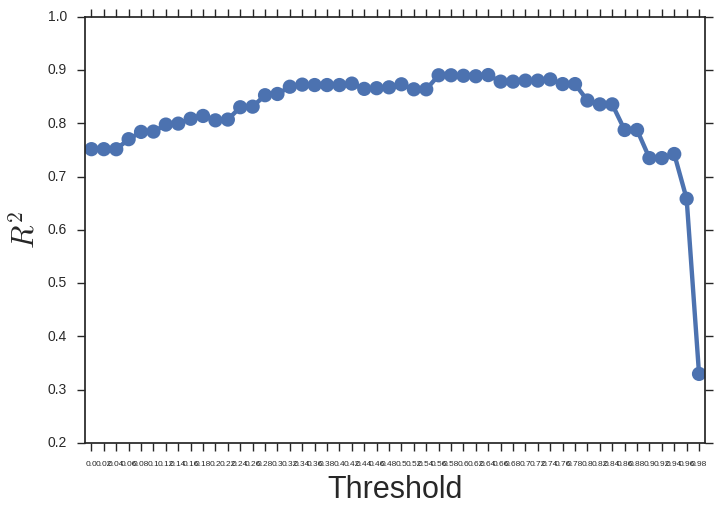

In [13]:
plt.figure()
sns.pointplot(thresholds,r2_scores, scatter_kws={"s": 0.7})
plt.xlabel('Threshold', size=22)
plt.xticks(size=6)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.show()

Choose the value for which the $R^2$ is maximal: 

In [14]:
r2_max = r2_scores.max()
r2_max_idx = r2_scores.argmax()
thresh_max = thresholds[r2_max_idx]
print('R2 max = ' + str(r2_max))
print('Optimal threshold = ' + str(thresh_max))

R2 max = 0.890549539147
Optimal threshold = 0.64


In [15]:
optimal_scores = otus_prod_scores[otus_prod_scores.values>thresh_max]
selected_otus = optimal_scores.index
print('Number of selected OTUs: ' + str(len(selected_otus)))

alphas_opt, preds_opt = perform_nested_lasso_cv(data_abs[selected_otus], hna)
r2_final = get_r2(hna, preds_opt)
print('r2: ' + str(r2_final))

Number of selected OTUs: 24
r2: 0.889099075728


This result is quite good, the $R^2$ is of course lower than using an initial filtering based on all samples, but only retaining those OTU's which are significantly present in the productivity samples results in an $R^2 = 0.889$! **(without outlier removal $R^2 = 0.893$);** Moreover, we are left with **24 OTU's** (instead of 29!). 

However, we can perform the same analysis to find the optimal threshold, but instead of using the $R^2$ between HNA and the predicted HNA, we can calculate the $R^2$ of the linear regression between the predicted HNA and the productivity, as this has an initial $R^2$ of roughly 0.6: 

**To avoid confusions:** This is a different kind of $R^2$, in this case we use the correlation between the predicted HNA-counts and the productivity, in previous cases the $R^2$ betwee predicted and true values is reported. Difference between the first and the latter is that the first lies in $[0,1]$, while the latter lies within $[-1,1]$, with negative values comprising predictions worse than random guessing. For the paper I suggest to replace the first $R^2$ by the root mean squared error (RMSE) between the true and predicted values. 

In [16]:
thresholds = np.arange(0,1,0.02)
r2_scores = np.zeros(len(thresholds))
dummy=0

#Make copy of otu_scores to be able to rerun analysis: 
scores = otus_prod_scores
for thresh in thresholds: 
    scores = otus_prod_scores[otus_prod_scores.values > thresh]
#scores_nested_mean = scores_nested_mean[scores_nested_mean > 0.16]
    features_new = scores.index
    if(len(features_new) > 0): 
        #alphas, preds = perform_nested_ridge_cv(data_abs[features_new],hna)
        alphas, preds = perform_nested_lasso_cv(data_abs[features_new],hna)
        #Check the R2 of the linear regression between the HNA-predictions and productivity 
        r2_scores[dummy] = linregress(prod[idx_prod],preds[idx_prod])[2]**2
    dummy+=1

/home/prubbens/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


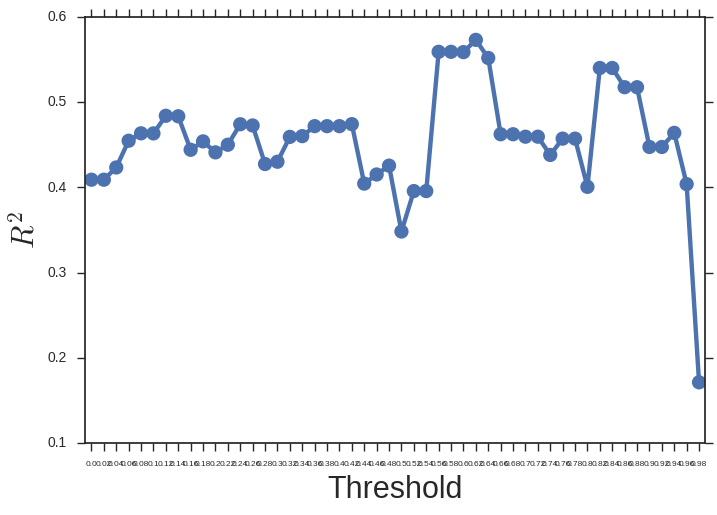

In [17]:
plt.figure()
sns.pointplot(thresholds,r2_scores, scatter_kws={"s": 0.7})
plt.xlabel('Threshold', size=22)
plt.xticks(size=6)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.show()

Again, let's select the optimal threshold for the scores: 

In [18]:
r2_max = r2_scores.max()
r2_max_idx = r2_scores.argmax()
thresh_max = thresholds[r2_max_idx]
print('R2 max = ' + str(r2_max))
print('Optimal threshold = ' + str(thresh_max))

R2 max = 0.572886666728
Optimal threshold = 0.62


In [19]:
optimal_scores = otus_prod_scores[otus_prod_scores.values>thresh_max]
selected_otus = optimal_scores.index
print('Number of selected OTUs: ' + str(len(selected_otus)))

Number of selected OTUs: 28


This gives us **28 OTU's** (instead of 12!)

In [20]:
from analysis_functions import perform_nested_lasso_loocv
alphas, preds = perform_nested_lasso_loocv(data_abs.loc[idx_prod,selected_otus], prod)

print('R2 productivity: ' + str(str(get_r2(prod, preds))))

R2 productivity: 0.366951479121


This $R^2$( = 0.37) looks better than the previous reported $R^2$ ( = -0.06) with outlier samples . 

In [21]:
optimal_scores = pd.DataFrame(optimal_scores, index=selected_otus)
p = np.zeros(len(selected_otus))
r = np.zeros(len(selected_otus))
t = 0
for otu in selected_otus: 
    output = linregress(prod,data_abs.loc[idx_prod,otu])
    r[t] = output[2]
    p[t] = output[3]
    t+=1
optimal_scores['correlation'] = r
optimal_scores['p'] = p
display(optimal_scores)
    

,0,correlation,p
Otu000027,0.992,0.153264,0.518855
Otu000123,0.986,0.339463,0.143120
Otu000043,0.980,0.325525,0.161350
Otu000040,0.980,-0.435580,0.054900
Otu000057,0.978,0.212148,0.369213
Otu000176,0.978,0.605838,0.004638
Otu000005,0.968,0.304424,0.191893
Otu000067,0.962,0.426287,0.060898
Otu000048,0.954,0.378197,0.100139
Otu000029,0.946,-0.032915,0.890430


Let's visualize the OTU's which have a $p\text{-value}<0.1$:

In [22]:
selected_otus_prod = optimal_scores[optimal_scores.p < 0.1].index
print('Number of correlated OTUs: ' + str(len(selected_otus_prod)))
print('OTUs that have a significant correlation:')
display(selected_otus_prod)

Number of correlated OTUs: 11
OTUs that have a significant correlation:


Index(['Otu000040', 'Otu000176', 'Otu000067', 'Otu000025', 'Otu000041',
       'Otu000042', 'Otu000016', 'Otu000219', 'Otu000050', 'Otu000034',
       'Otu000082'],
      dtype='object')

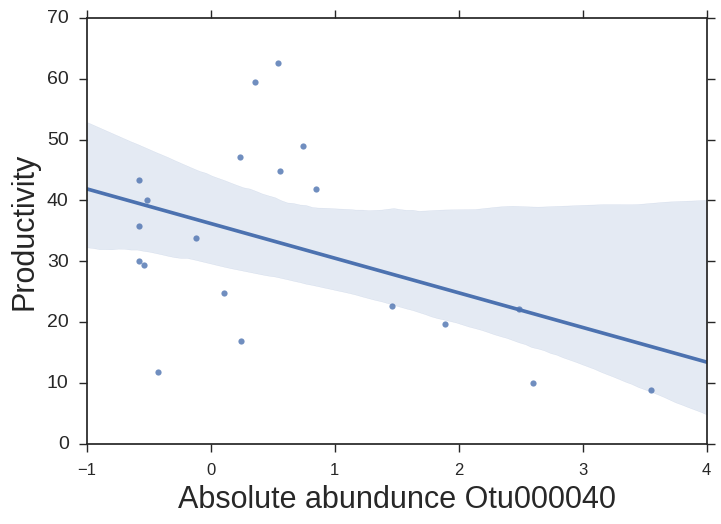

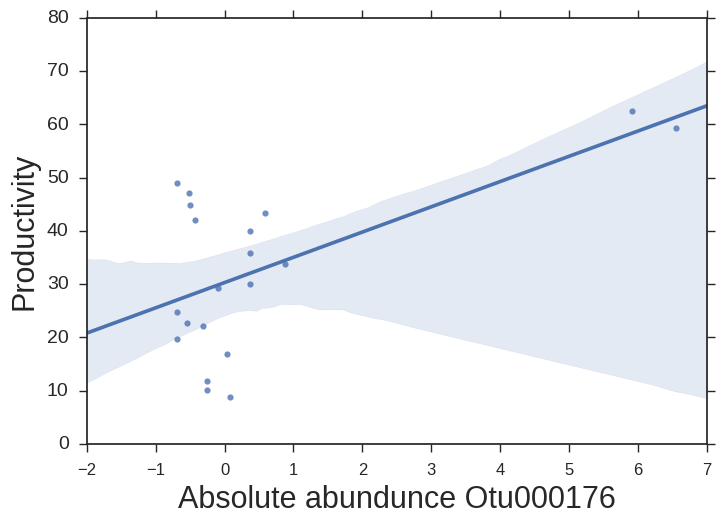

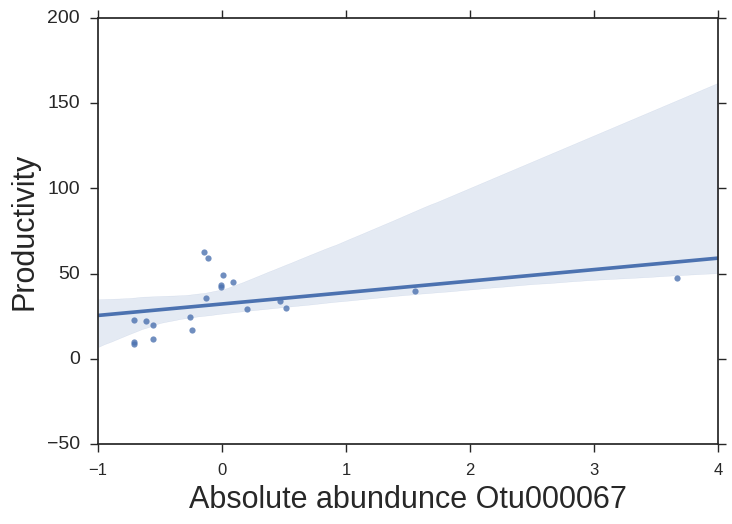

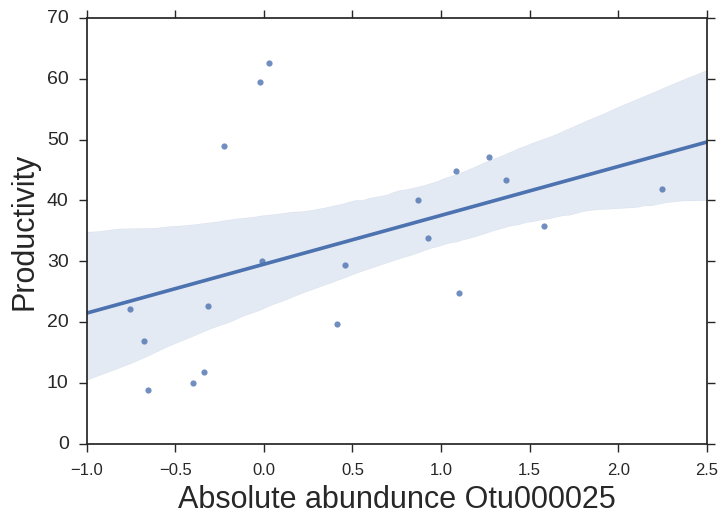

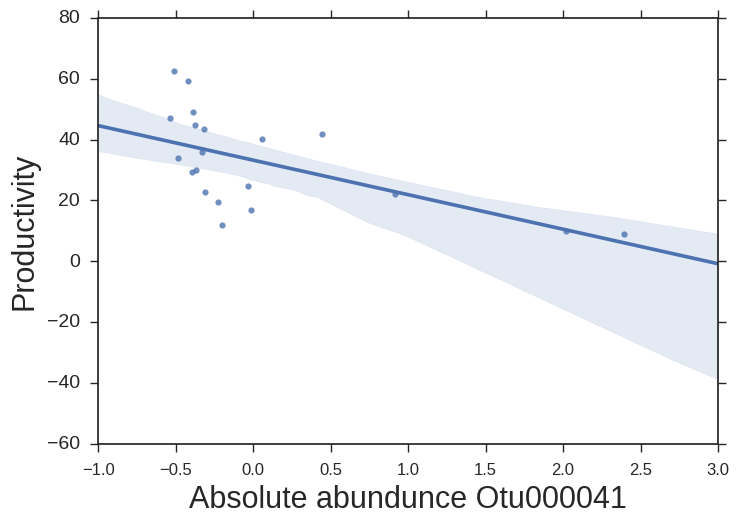

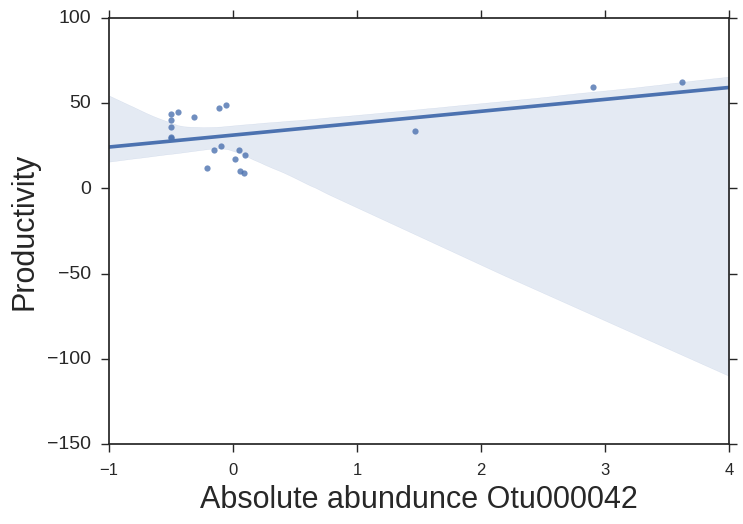

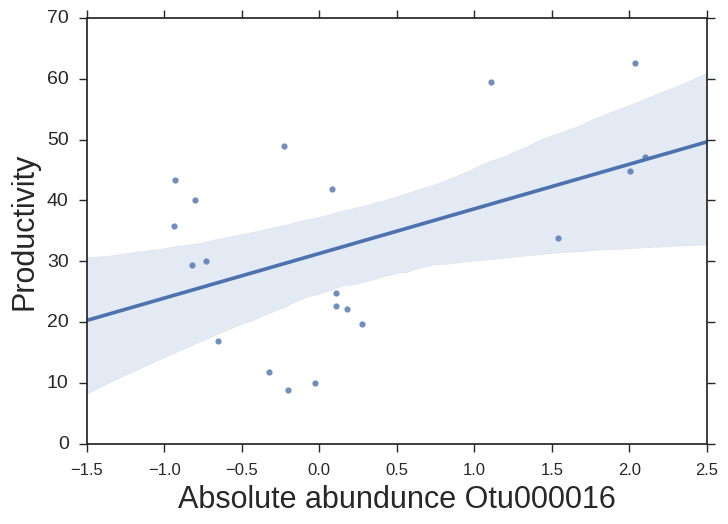

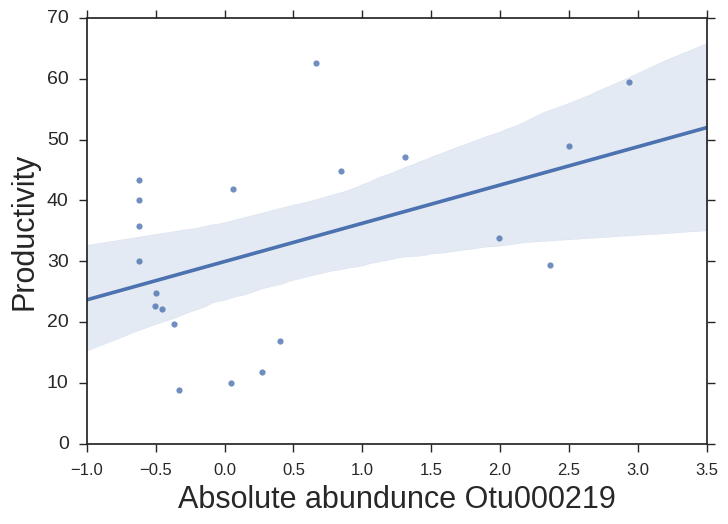

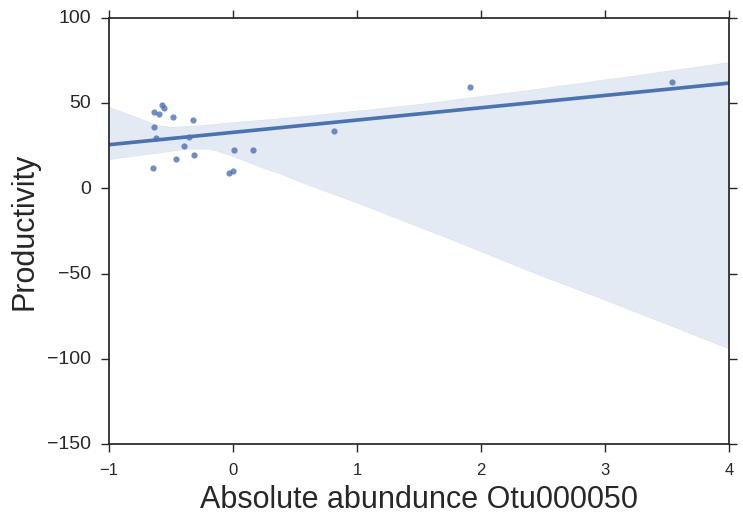

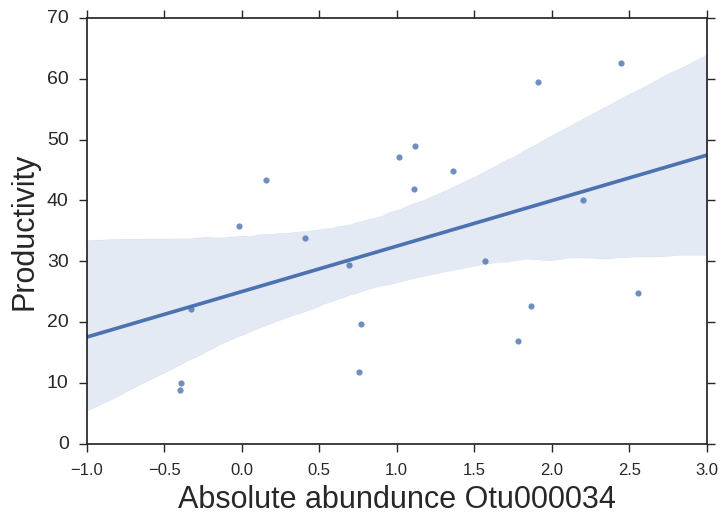

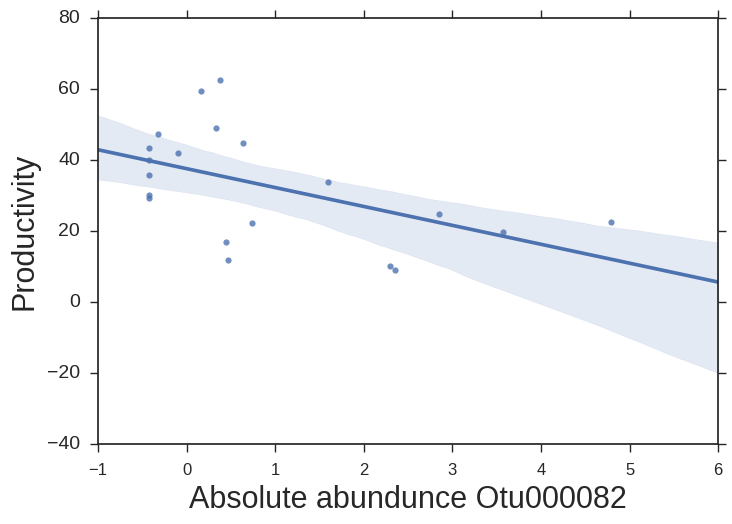

In [23]:
for otu in selected_otus_prod: 
    plt.figure()
    sns.regplot(data_abs.loc[idx_prod, otu], prod)
    plt.xlabel('Absolute abundunce ' + otu, size=22)
    plt.xticks(size=12)
    plt.ylabel('Productivity', size=22)
    plt.yticks(size=14)
    plt.show()

**MAIN CONCLUSIONS COMPARED TO INCLUSION OF OUTLIER SAMPLES: **

- List of OTU's based on initial filtering is roughly the same (95 instead of 97); 
- Therefore, $R^2$ determined by randomized Lasso remains also the same. It gives rise to a final selection of 28 OTU's instead of 29; 

- Determining the 'optimal' set of OTU's in function of the productivity gives rise to (the same) 28 OTU's (instead of the previous 12); 
- These 28 OTU's give rise to a positive $R^2$ (=0.37) using a LOOCV-scheme for the productivity. Including the outlier samples resulted in a negative $R^2$. In other words, significant improvement! 
- Amongst these 28 OTU's there are 11 which are directly correlated ($p < 0.1$). Three of these were initially also selected when outlier samples were included. 

**To do: **
- Include only those samples with initial correlation to productivity. 

Let's try and fit the absolute abundances of those only those OTU's that are significantly correlated to the productivity: 

In [24]:
alphas, preds = perform_nested_lasso_loocv(data_abs.loc[idx_prod,selected_otus_prod], prod)

print('R2 productivity based on correlated OTUs: ' + str(str(get_r2(prod, preds))))

R2 productivity based on correlated OTUs: 0.517794742588
